In [2]:
import os
import requests
import random
import json
import numpy as np

from skimage import io
from skimage.transform import resize

from scipy import ndimage
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from matplotlib import patches, transforms as plt_transforms

rcParams['figure.figsize'] = [16, 6]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
def unpack_bbox(bbox):
  #bbox as in the json/COCO data format (centerx, centery, width, height, theta is in radians)

  rot_center = np.array((bbox[1], bbox[0])).T
  width = bbox[3]
  height = bbox[2]
  theta = -bbox[4]+np.pi/2 #radians
  return rot_center, width, height, theta


def rotcorners_from_coords(rot_center, width, height, theta):
  rotation = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta))))

  wvec = np.dot(rotation, (width/2, 0))
  hvec = np.dot(rotation, (0, height/2))
  corner_points = rot_center + [wvec+hvec, wvec-hvec, -wvec+hvec, -wvec-hvec]
  return corner_points


def rotbbox_from_coords(rot_center, width, height, theta):
  corner_points = rotcorners_from_coords(rot_center, width, height, theta)
  rot_bbox = np.array((corner_points.min(0), corner_points.max(0))).astype(np.int)
  #constrain inside image
  rot_bbox[rot_bbox < 0] = 0

  return rot_bbox


def extract_subimg_bbox(im, bbox):
  return extract_subimg(im, *unpack_bbox(bbox))


def extract_subimg(im, rot_center, width, height, theta):
  rot_bbox = rotbbox_from_coords(rot_center, width, height, theta)

  subimg = im[rot_bbox[0,1]:rot_bbox[1,1],rot_bbox[0,0]:rot_bbox[1,0]]
  rotated_im = ndimage.rotate(subimg, np.degrees(theta)+180)
  newcenter = (np.array(rotated_im.shape)/2).astype(np.int)
  rotated_im = rotated_im[int(newcenter[0]-height/2):int(newcenter[0]+height/2), int(newcenter[1]-width/2):int(newcenter[1]+width/2), :3]  #drop alpha channel, if it's there

  return rotated_im

In [13]:
datapath = "../datasets/"
print(os.getcwd())
print(os.listdir(datapath))
with open(os.path.join(datapath, 'screws.json')) as f:
  data = json.load(f)

print(data.keys())
print(data['images'][0])
print(data['annotations'][0])

/home/alesmelichar/Dev/network/client/yolo
['json', 'coco128', 'screws.json', 'merged']
dict_keys(['categories', 'images', 'annotations'])
{'file_name': 'screws_167.png', 'height': 640, 'width': 640, 'id': 167, 'license': 1}
{'area': 10836.0, 'bbox': [118.0, 224.5, 84.0, 129.0, 0], 'category_id': 1, 'id': 1001, 'image_id': 167, 'is_crowd': 0}


In [15]:
imgdir = os.path.join(datapath, 'images')

#remap images to dict by id
imgdict = {l['id']:l for l in data['images']}
#read in all images, can take some time
for i in imgdict.values():
  i['image'] = io.imread(os.path.join(imgdir, i['file_name']))[:, :,: 3]  # drop alpha channel, if it's there

In [16]:
# remap annotations to dict by image_id
from collections import defaultdict
annodict = defaultdict(list)
for annotation in data['annotations']:
  annodict[annotation['image_id']].append(annotation)

print(annodict)

# setup list of categories
categories = data['categories']
ncategories = len(categories)
cat_ids = [i['id'] for i in categories]

category_names = {1:'leskla skrutka', 2:'dlha skrutka do dreva', 3:'mala skrutka do sadrokartonu', 4:'skrutka do sadrokartonu',
                  5:'mala skrutka do dreva', 6:'strojova skrutka', 7:'mala matica', 8:'stredna matica', 9:'velka matica'}

defaultdict(<class 'list'>, {167: [{'area': 10836.0, 'bbox': [118.0, 224.5, 84.0, 129.0, 0], 'category_id': 1, 'id': 1001, 'image_id': 167, 'is_crowd': 0}, {'area': 7663.0, 'bbox': [257.5, 429.5, 97.0, 79.0, 0], 'category_id': 2, 'id': 1002, 'image_id': 167, 'is_crowd': 0}, {'area': 3136.0, 'bbox': [468.0, 479.0, 56.0, 56.0, 0], 'category_id': 3, 'id': 1003, 'image_id': 167, 'is_crowd': 0}, {'area': 8075.0, 'bbox': [98.5, 526.5, 95.0, 85.0, 0], 'category_id': 4, 'id': 1004, 'image_id': 167, 'is_crowd': 0}, {'area': 8162.0, 'bbox': [474.5, 228.0, 77.0, 106.0, 0], 'category_id': 4, 'id': 1005, 'image_id': 167, 'is_crowd': 0}], 161: [{'area': 6912.0, 'bbox': [522.0, 463.0, 72.0, 96.0, 0], 'category_id': 5, 'id': 1006, 'image_id': 161, 'is_crowd': 0}, {'area': 4444.0, 'bbox': [299.5, 315.0, 101.0, 44.0, 0], 'category_id': 5, 'id': 1007, 'image_id': 161, 'is_crowd': 0}, {'area': 9882.0, 'bbox': [79.0, 135.5, 122.0, 81.0, 0], 'category_id': 1, 'id': 1008, 'image_id': 161, 'is_crowd': 0}, {'a

[174.98019801980197, 48.712871287128706, 72.0, 73.0, 0]
[181.98019801980195, 152.7128712871287, 211.0, 59.0, 0]
[120.98019801980197, 292.7128712871287, 33.0, 68.0, 0]
[140.98019801980197, 306.7128712871287, 78.0, 72.0, 0]
[298.98019801980195, 356.7128712871287, 90.0, 57.0, 0]
[347.98019801980195, 225.71287128712868, 38.0, 103.0, 0]
[370.98019801980195, 288.7128712871287, 25.0, 38.0, 0]
[283.98019801980195, 65.7128712871287, 49.0, 67.0, 0]
[226.98019801980195, 201.71287128712868, 61.0, 76.0, 0]
[219.98019801980195, 326.7128712871287, 62.0, 106.0, 0]


/home/alesmelichar/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


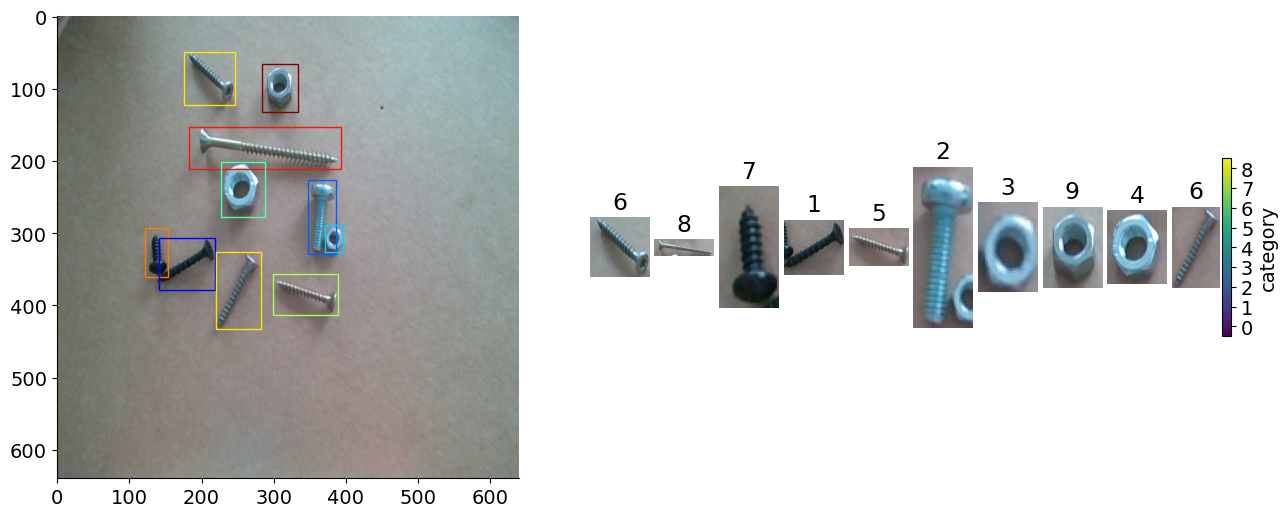

In [23]:
# Let's look at one image and it's associated annotations
imageid = 1
im = imgdict[imageid]['image']
gs = gridspec.GridSpec(1, 1 + len(annodict[imageid]), # width is 1 to 1+9(since we have 9 types)
                       width_ratios=[1,]+[.1]*len(annodict[imageid]),
                       wspace=.05)
plt.figure()
ax = plt.subplot(gs[0])
plt.imshow(im)
cmap_normal = plt.Normalize(0, ncategories)

for i, annotation in enumerate(annodict[imageid]):
    bbox = list(annotation['bbox'])
    # plt.scatter(*rot_center)
    # plt.scatter(*corner_points.T, c='r')

    ax = plt.subplot(gs[0])
    color = plt.cm.jet(cmap_normal(annotation['category_id']))    
    
    # Convert center x, y to lower left x, y - bbox[0] - x, bbox[1] - y, bbox[2] - width, bbox[3] - height
    bbox[0] = bbox[0] - bbox[2] / 2.0  # x - width / 2
    bbox[1] = bbox[1] - bbox[3] / 2.0  # y - height / 2
    print(bbox)

    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor=color,facecolor='none')

    ax.add_patch(rect)
    sub_image = im[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2]), :]
    
    # Add the subplot for the sub-image in the second row
    plt.subplot(gs[i + 1])
    if sub_image.size > 0:
        plt.imshow(sub_image)
    plt.axis('off')
    plt.title(annotation['category_id'])

plt.colorbar(ticks=range(ncategories), label='category')
plt.clim(-0.5, ncategories - .5)
plt.show()

In [ ]:
# create a dict mapping category id to all subimages, can take some time to run
cat_imgdict = defaultdict(list)
for img_id, image in imgdict.items():
  for annotation in annodict[img_id]:
    bbox = list(annotation['bbox'])
    # Convert center x, y to lower left x, y - bbox[0] - x, bbox[1] - y, bbox[2] - width, bbox[3] - height
    bbox[0] = bbox[0] - bbox[2] / 2.0  # x - width / 2
    bbox[1] = bbox[1] - bbox[3] / 2.0  # y - height / 2
    sub_image = image['image'][int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2]), :]
    print(f"Subimage shape: {sub_image.shape}")  # This will print the shape of each subimage
    cat_imgdict[annotation['category_id']].append(sub_image.copy())


Subimage shape: (129, 84, 3)
Subimage shape: (79, 97, 3)
Subimage shape: (56, 56, 3)
Subimage shape: (85, 95, 3)
Subimage shape: (106, 77, 3)
Subimage shape: (96, 72, 3)
Subimage shape: (44, 101, 3)
Subimage shape: (81, 122, 3)
Subimage shape: (43, 40, 3)
Subimage shape: (96, 80, 3)
Subimage shape: (78, 113, 3)
Subimage shape: (127, 64, 3)
Subimage shape: (121, 70, 3)
Subimage shape: (63, 108, 3)
Subimage shape: (63, 64, 3)
Subimage shape: (147, 65, 3)
Subimage shape: (50, 36, 3)
Subimage shape: (98, 68, 3)
Subimage shape: (114, 64, 3)
Subimage shape: (307, 102, 3)
Subimage shape: (228, 201, 3)
Subimage shape: (49, 43, 3)
Subimage shape: (52, 45, 3)
Subimage shape: (42, 42, 3)
Subimage shape: (55, 49, 3)
Subimage shape: (46, 45, 3)
Subimage shape: (77, 104, 3)
Subimage shape: (119, 83, 3)
Subimage shape: (305, 48, 3)
Subimage shape: (70, 46, 3)
Subimage shape: (131, 62, 3)
Subimage shape: (137, 36, 3)
Subimage shape: (93, 80, 3)
Subimage shape: (100, 93, 3)
Subimage shape: (113, 83, 3)

In [ ]:
# How many images are in each category?
for k, v  in cat_imgdict.items():
  print(f"Category ID {k} has {len(v)} items")

Category ID 1 has 257 items
Category ID 2 has 120 items
Category ID 3 has 152 items
Category ID 4 has 194 items
Category ID 5 has 198 items
Category ID 6 has 163 items
Category ID 7 has 201 items
Category ID 8 has 147 items
Category ID 9 has 123 items


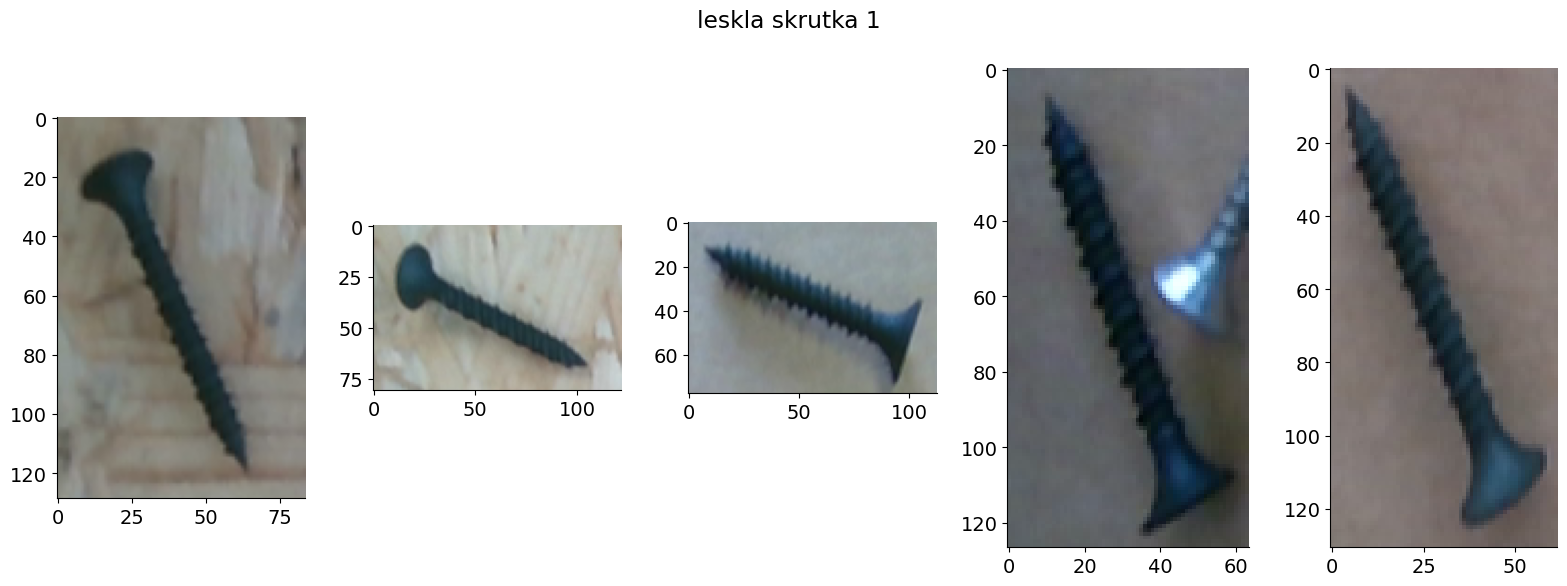

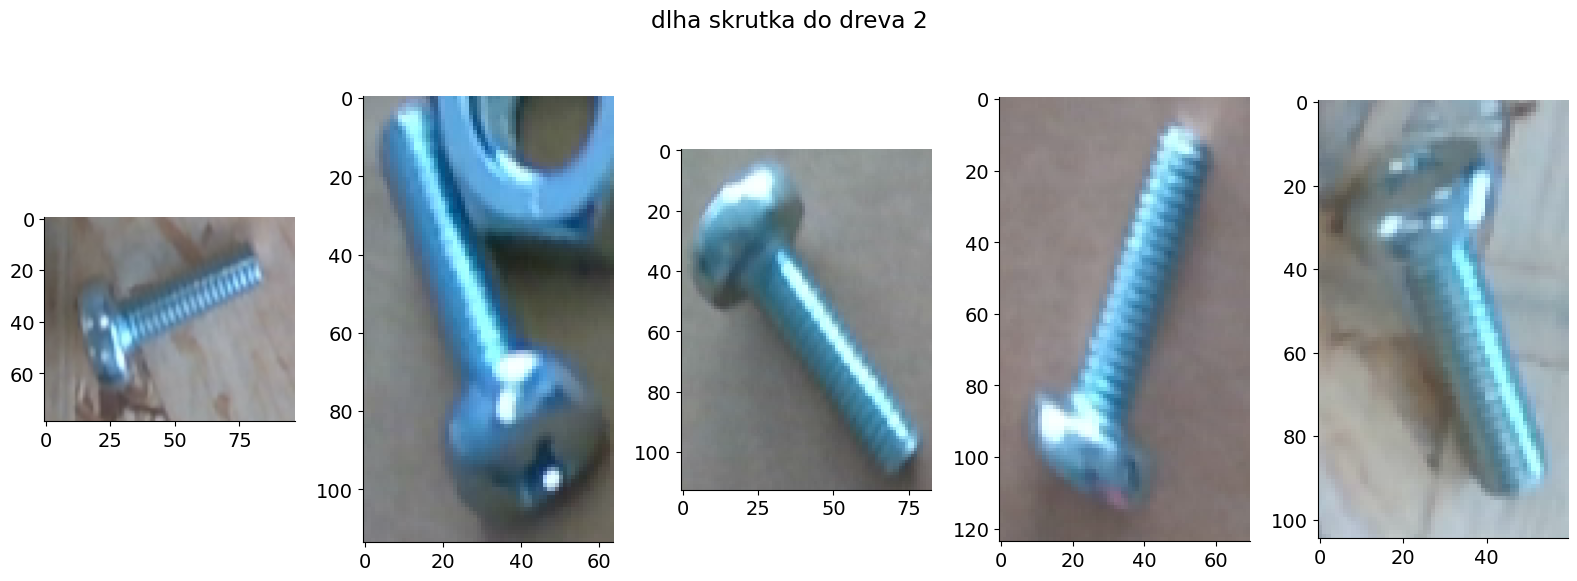

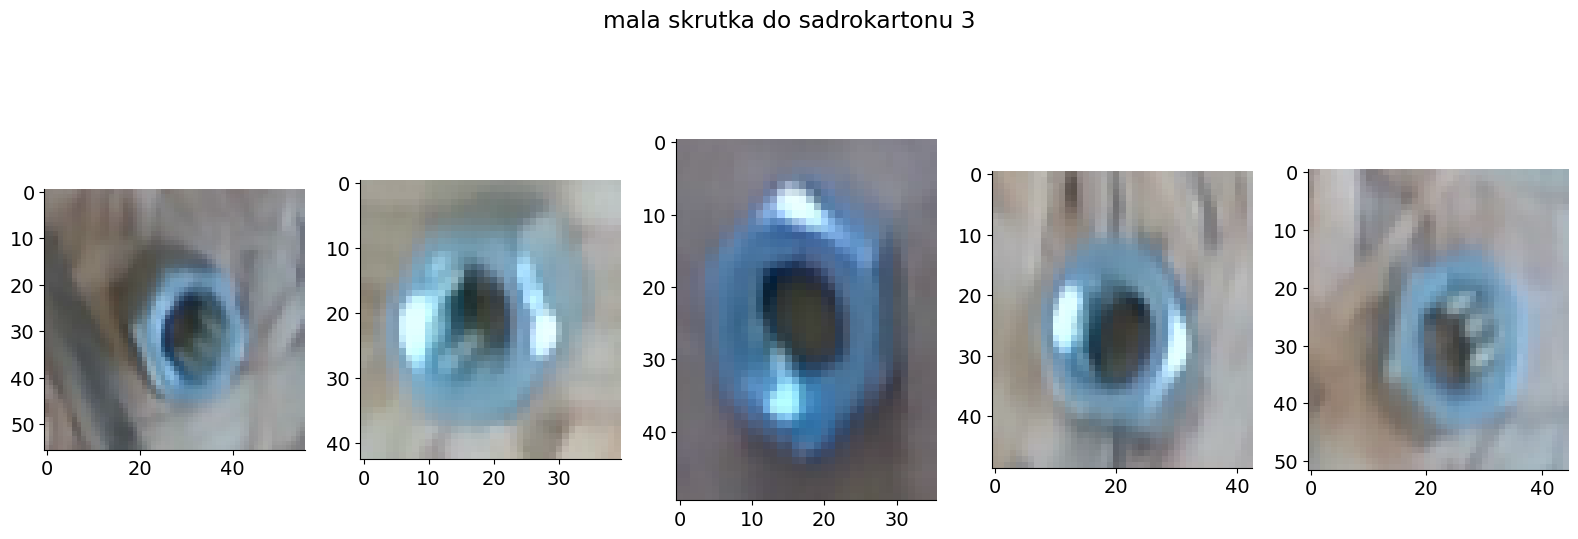

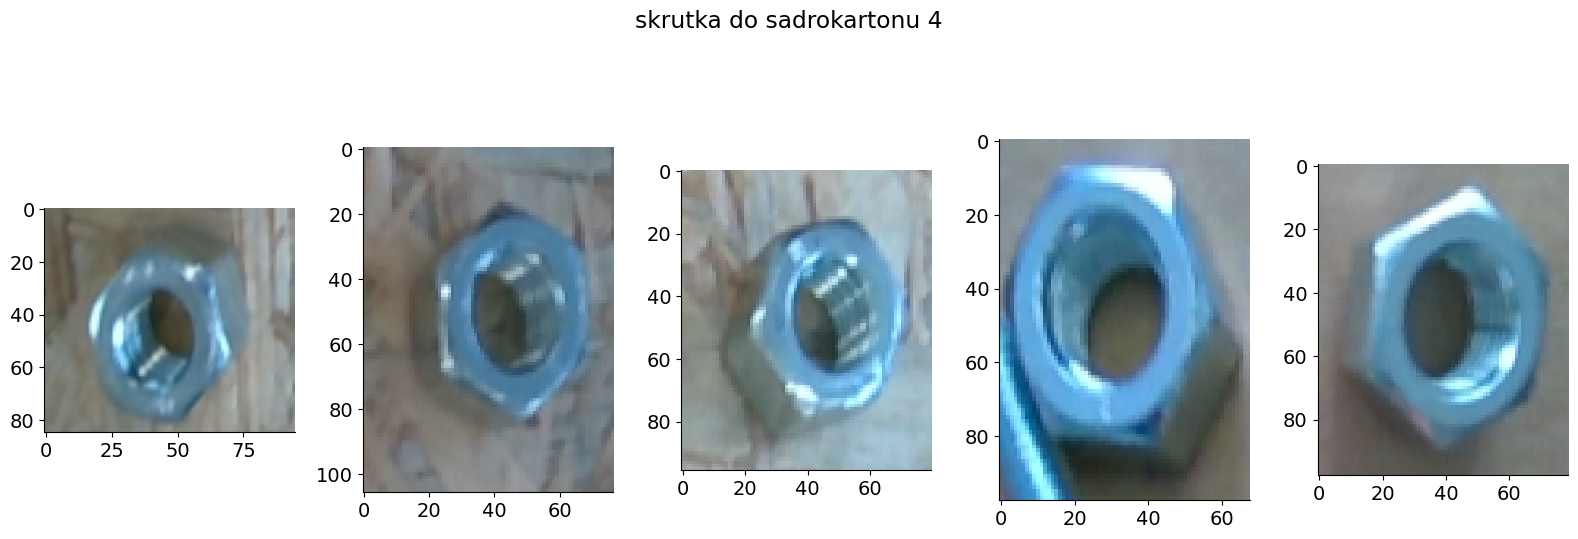

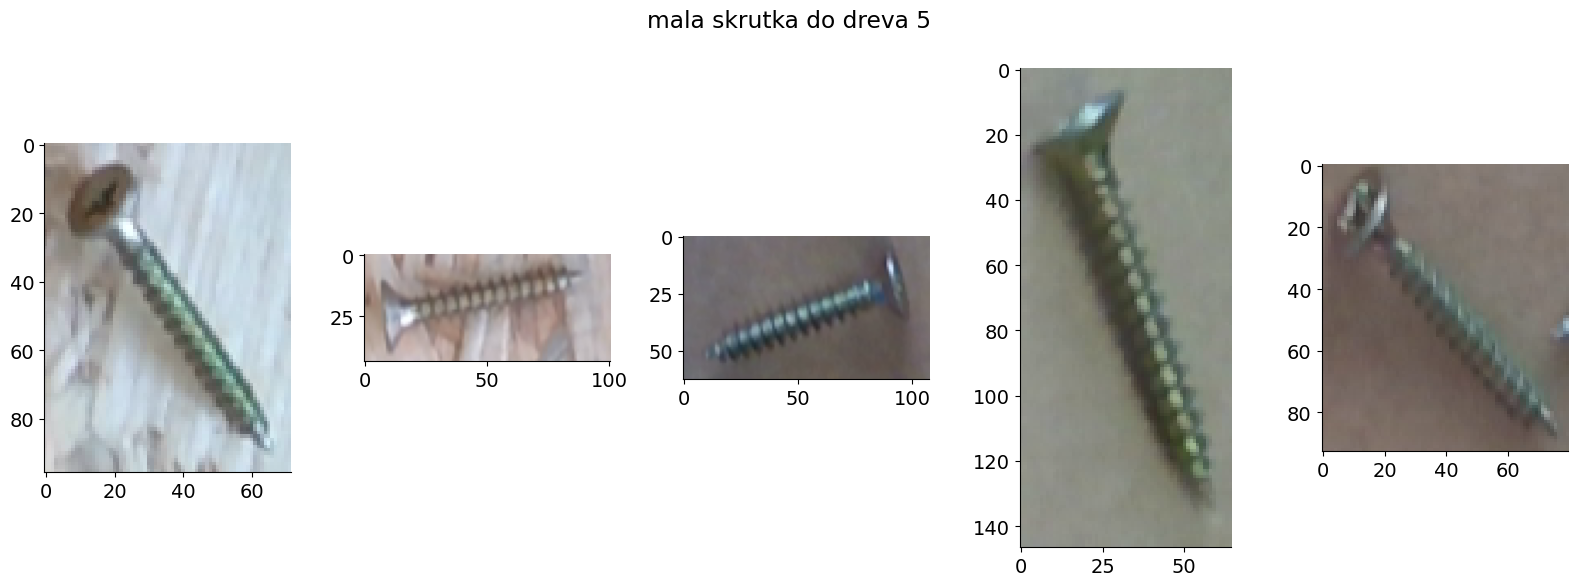

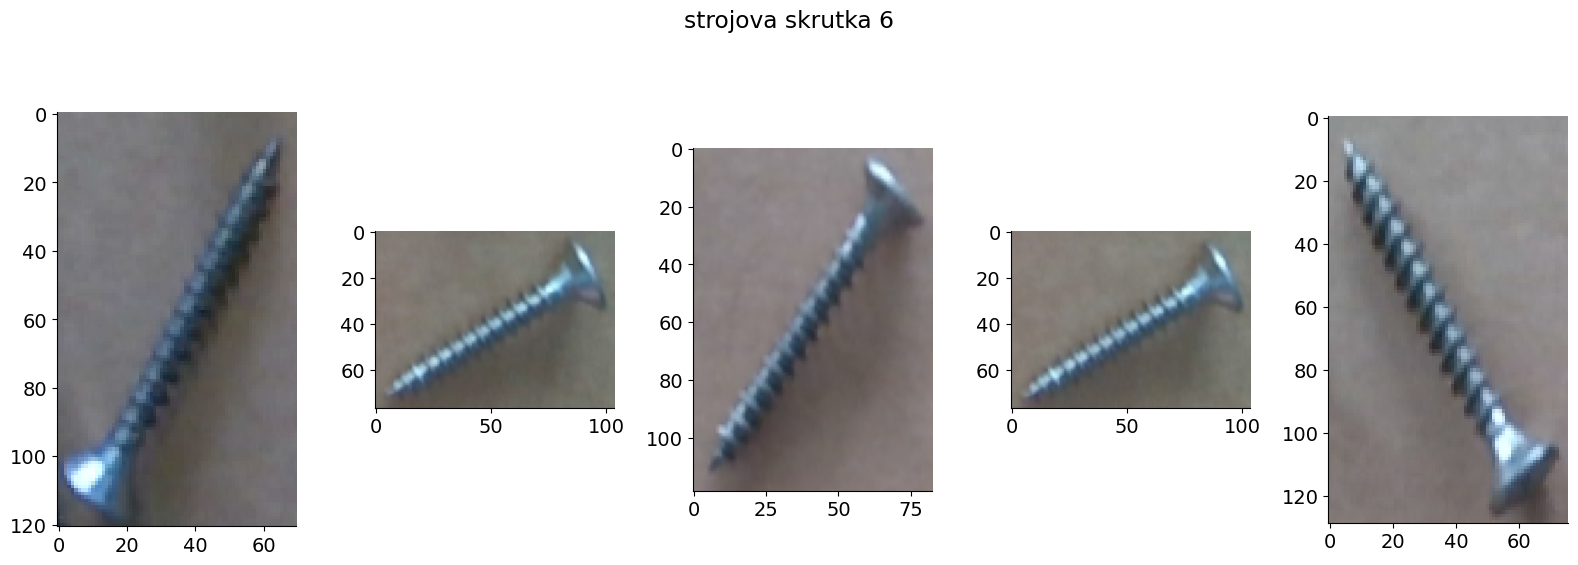

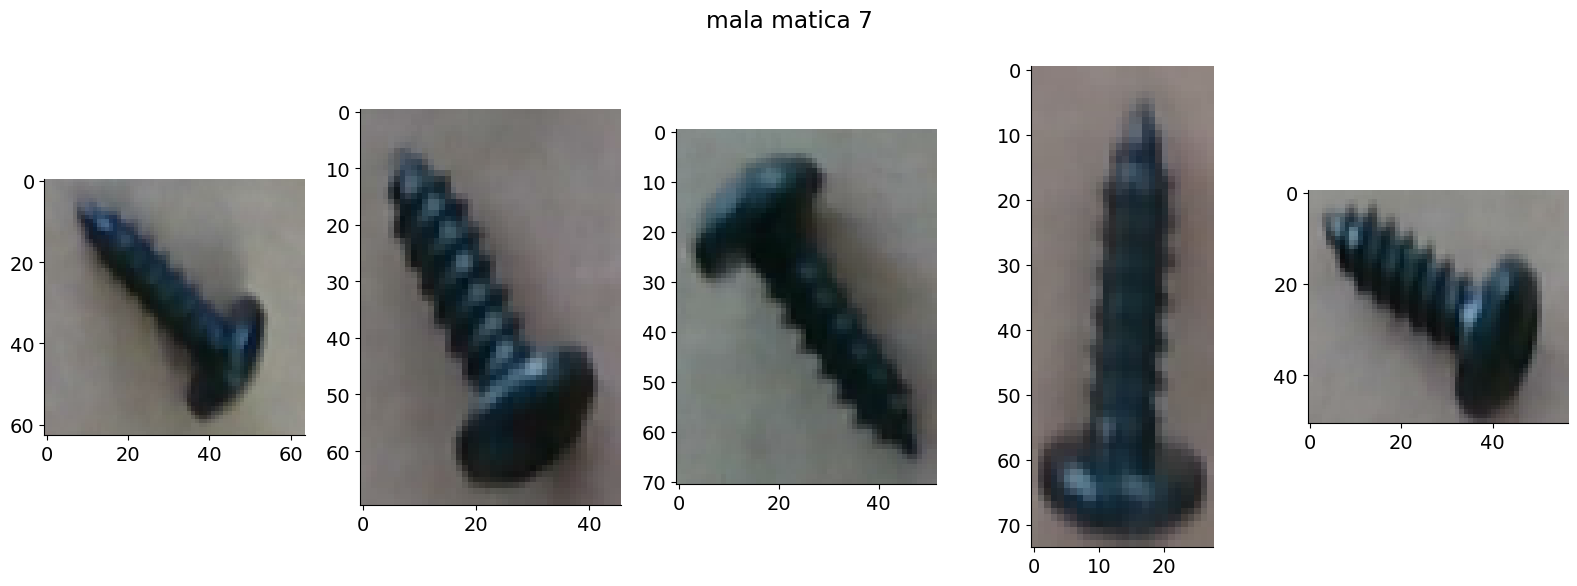

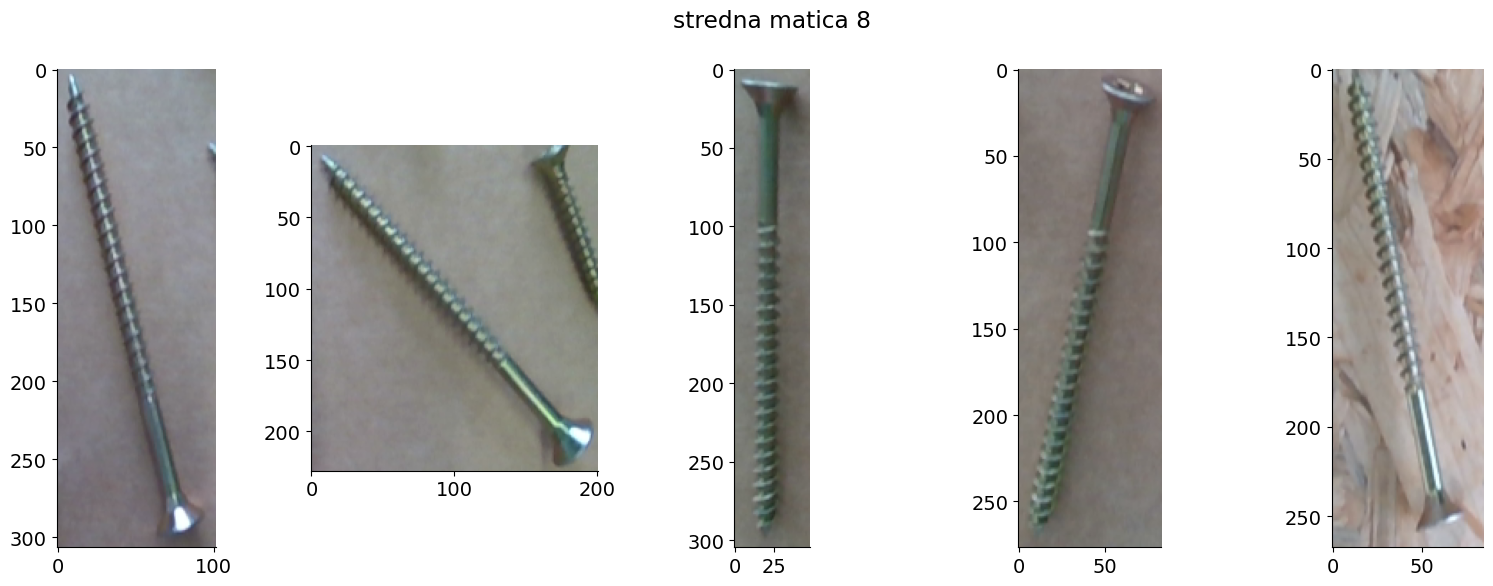

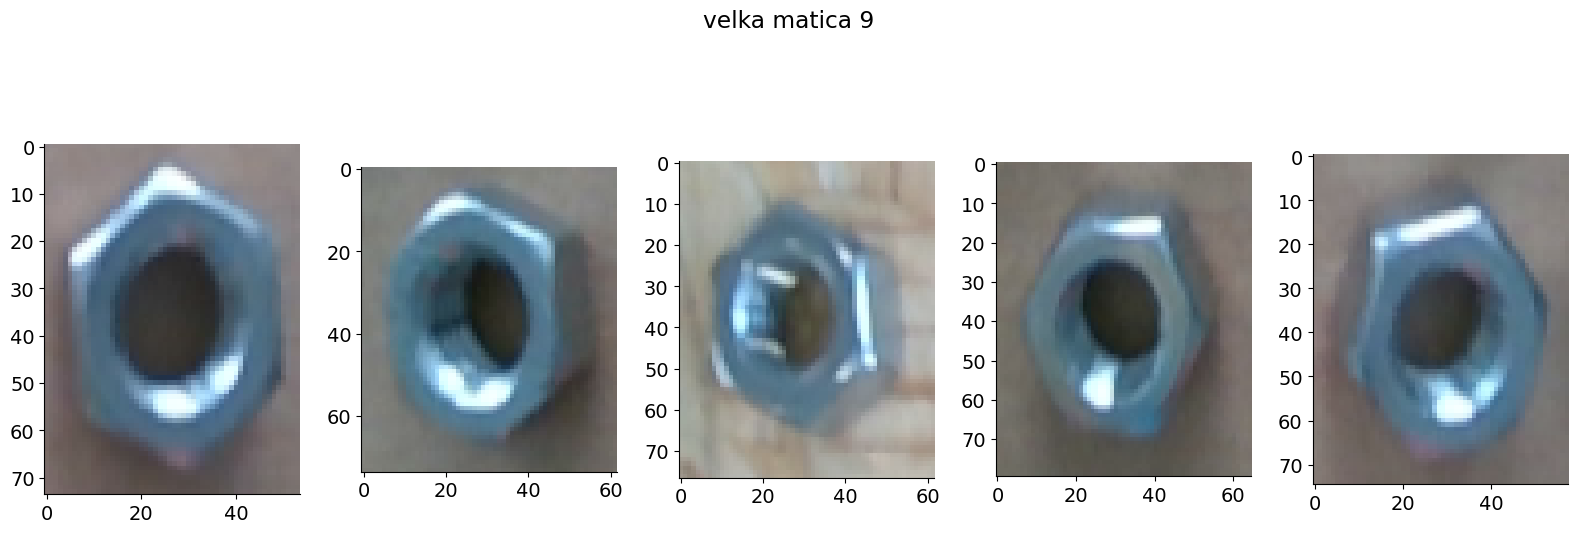

In [ ]:
# Plot some examples from each category
for catid, examples in cat_imgdict.items():
  num_examples = 5
  gs = gridspec.GridSpec(1, num_examples)
  plt.figure()
  for i, example in enumerate(examples[:num_examples]):
    plt.subplot(gs[i])
    plt.imshow(example)
    plt.suptitle(f"{category_names[catid]} {catid}")

/home/alesmelichar/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


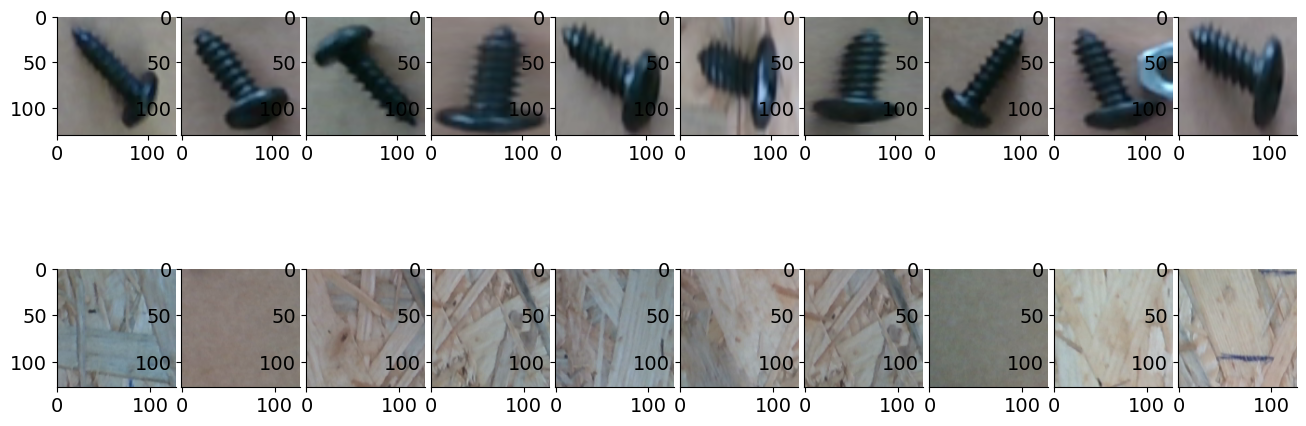

In [ ]:
# Start with fixed sized patches that either have a screw or not
use_categories = [7, 10]
# for screw patches use categories that have smaller bounding boxes
patch_size = np.array((128, 128))
num_patches_per_category = 500

nut_patches = []
for img_id, image in imgdict.items():
  for annotation in annodict[img_id]:
    if annotation['category_id'] in use_categories:
      bbox = list(annotation['bbox'])
      
      bbox[0] = bbox[0] - bbox[2] / 2.0  # x - width / 2
      bbox[1] = bbox[1] - bbox[3] / 2.0  # y - height / 2
      sub_image = image['image'][int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2]), :]
      
      # If size is zero or any dimension is zero, skip this loop iteration
      if sub_image.size == 0 or any(dim == 0 for dim in sub_image.shape):
        continue 

      # Only resize the subimage if it doesn't match the patch size
      if not all(sub_image.shape[:2] == patch_size):
        sub_image = resize(sub_image, patch_size + (3,), mode='reflect')

      nut_patches.append(sub_image)
      # plt.figure()
      # plt.imshow(sub_image)

  if len(nut_patches) >= num_patches_per_category:
    break

#Select random blank patches
blank_patches = []
for i in range(len(nut_patches)):
  while True: #until a suitable random patch is found
    #choose random image
    imgid, imgobj = random.choice(list(imgdict.items()))
    im = imgobj['image']
    #choose random place at least half a patch size from edges
    rand_center = np.random.randint((patch_size//2), np.array(im.shape)[:2] - patch_size//2)
    corners = rotcorners_from_coords(rand_center, patch_size[0], patch_size[1], 0)
    #check if the random patch intersects with any labeled objects
    if not any([Polygon(corners).intersects(Polygon(rotcorners_from_coords(*unpack_bbox(annotation['bbox'])))) for annotation in annodict[imgid]]):
      rand_patch = im[rand_center[0]-patch_size[0]//2:rand_center[0]+patch_size[0]//2, rand_center[1]-patch_size[1]//2:rand_center[1]+patch_size[1]//2]
      blank_patches.append(rand_patch)
      break

# TODO seems like rarely the patches aren't fully blank - are some labels missing??

# could also use some images from cifar etc.
num_examples = 10
plt.figure()
gs = gridspec.GridSpec(2, num_examples, wspace=.05)
for i in range(num_examples):
  plt.subplot(gs[0, i])
  plt.imshow(nut_patches[i])
  plt.subplot(gs[1, i])
  plt.imshow(blank_patches[i])

patch_labels = [1,]*len(nut_patches) + [0,]*len(blank_patches)  #1 if nut
all_patches = nut_patches + blank_patches #list concat

# randomly shuffle
shuffle_idx = np.random.choice(len(patch_labels), len(patch_labels), replace=False)
patch_labels = [patch_labels[i] for i in shuffle_idx]
all_patches = [all_patches[i] for i in shuffle_idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


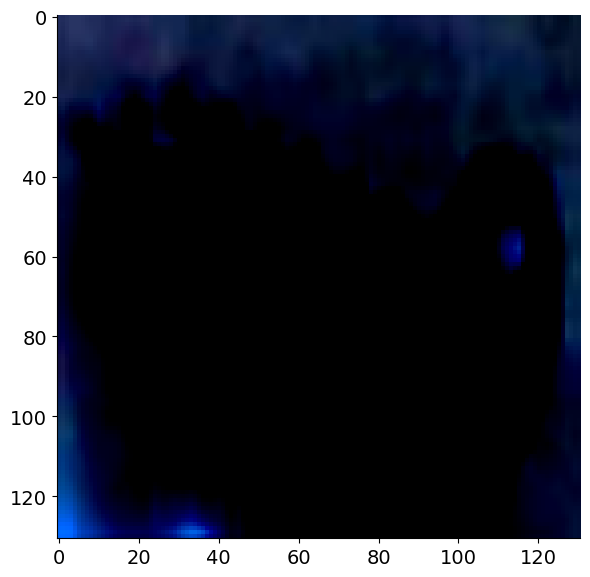

In [ ]:
# Preprocess data
preprocess = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_frac = .2
train_number = int(len(all_patches)*train_frac)
# test_nuumber = all_patches.len()-train_number
train_patches, train_labels = all_patches[:train_number], patch_labels[:train_number]
test_patches, test_labels = all_patches[train_number:], patch_labels[train_number:]

plt.figure()
plt.imshow(preprocess(all_patches[0]).permute(1, 2, 0))
plt.show()

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())


2023-05-26 22:05:06.388895: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 22:05:06.687562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 22:05:07.902992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['/device:GPU:0']


2023-05-26 22:05:09.595405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 22:05:09.622661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 22:05:09.622925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 22:05:13.263519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 22:05:13.263785: I tensorflow/compile

Premena json na txt

In [46]:
# Load the COCO style JSON
with open("..//datasets//screws.json") as f:
    data = json.load(f)

# Create a dictionary to map category ids to new ids starting from 0
category_map = {category["id"]: idx for idx, category in enumerate(data["categories"])}
image_width = 640.0
image_height = 640.0
# Iterate over all annotations
for annotation in data["annotations"]:
    image_id = annotation["image_id"]
    category_id = category_map[annotation["category_id"]]
    bbox = annotation["bbox"]

    # COCO bbox format is [top left x position, top left y position, width, height]
    # Convert COCO bbox format to YOLO format [x_center, y_center, width, height]
    # bbox_yolo = [
    #     (bbox[0] + bbox[2] / 2) / image_width,
    #     (bbox[1] + bbox[3] / 2) / image_height,
    #     bbox[2] / image_width,
    #     bbox[3] / image_height,
    # ]
    # Convert to YOLO format (x_center, y_center, width, height) in normalized coordinates
    bbox_yolo = [bbox[0] / im.shape[1], # x_center
             bbox[1] / im.shape[0], # y_center
             bbox[2] / im.shape[1], # width
             bbox[3] / im.shape[0]] # height
    # Create txt file for each image in the YOLO format
    with open(os.path.join("..//datasets//labels", f"screws_{str(image_id).zfill(3)}.txt"), "a") as f:
        f.write(f"{category_id} {' '.join(map(str, bbox_yolo))}\n")


Divide dataset to training, validation and testing

In [47]:
import os
import shutil
import numpy as np
import glob
# set the path to your dataset
dataset_path = "/home/alesmelichar/Dev/network/client/datasets/coco128/wo_division"

image_files = sorted(glob.glob(os.path.join(dataset_path, "images/*.png")))
label_files = sorted(glob.glob(os.path.join(dataset_path, "labels/*.txt")))

print(image_files[9:10])
print(label_files[9:10])

assert len(image_files) == len(label_files)

# generate a random distribution
num_files = len(image_files)
print(num_files)
indices = np.random.permutation(num_files)
train_idx, val_idx, test_idx = indices[:int(num_files*0.7)], indices[int(num_files*0.7):int(num_files*0.85)], indices[int(num_files*0.85):]

# create necessary directories
os.makedirs(os.path.join(dataset_path, "images/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "images/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "images/test"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/test"), exist_ok=True)

# move files to respective directories
for i in train_idx:
    shutil.move(image_files[i], os.path.join(dataset_path, "images/train", os.path.basename(image_files[i])))
    shutil.move(label_files[i], os.path.join(dataset_path, "labels/train", os.path.basename(label_files[i])))

for i in val_idx:
    shutil.move(image_files[i], os.path.join(dataset_path, "images/val", os.path.basename(image_files[i])))
    shutil.move(label_files[i], os.path.join(dataset_path, "labels/val", os.path.basename(label_files[i])))

for i in test_idx:
    shutil.move(image_files[i], os.path.join(dataset_path, "images/test", os.path.basename(image_files[i])))
    shutil.move(label_files[i], os.path.join(dataset_path, "labels/test", os.path.basename(label_files[i])))

['/home/alesmelichar/Dev/network/client/datasets/coco128/wo_division/images/screws_010.png']
['/home/alesmelichar/Dev/network/client/datasets/coco128/wo_division/labels/screws_010.txt']
199


In [21]:
directory_path = "/home/alesmelichar/Dev/network/client/datasets/coco128/wo_division/labels"
for file_name in os.listdir(directory_path):
    base_name, extension = os.path.splitext(file_name)
    new_name = str(int(base_name)).zfill(3) + extension  # add leading zeros until width of 3
    old_file_path = os.path.join(directory_path, file_name)
    new_file_path = os.path.join(directory_path, new_name)
    os.rename(old_file_path, new_file_path)  # rename the file

ValueError: invalid literal for int() with base 10: 'screws_1'

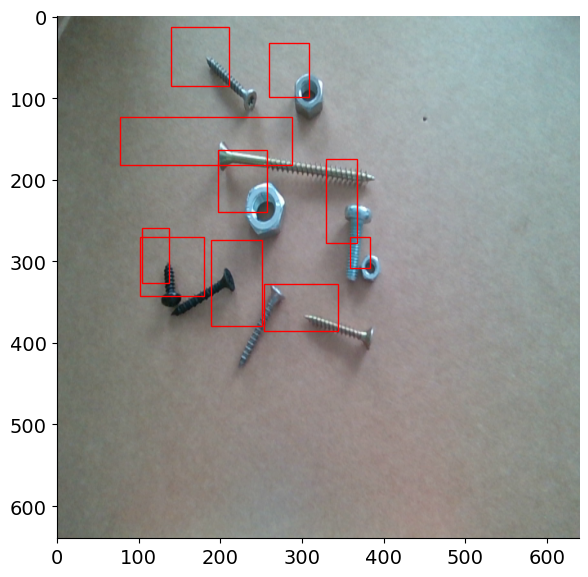

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Open the image file
im = np.array(Image.open('/home/alesmelichar/Dev/network/client/datasets/images/screws_001.png'), dtype=np.uint8)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Open the corresponding .txt file
with open('/home/alesmelichar/Dev/network/client/datasets/labels/screws_001.txt', 'r') as f:
    # For each line (object) in the file
    for line in f:
        # Split the line into parts
        parts = line.strip().split()
        
        # Get the class and bounding box coordinates (in YOLO format)
        obj_class, x_center, y_center, width, height = map(float, parts)

        # Convert YOLO coordinates to matplotlib coordinates
        # YOLO format: center_x center_y width height (relative to image size)
        # matplotlib format: left_x top_y width height (in absolute pixels)
        left = (x_center - width / 2.0) * im.shape[1]
        top = (y_center - height / 2.0) * im.shape[0]
        width = width * im.shape[1]
        height = height * im.shape[0]

        # Create a rectangle patch
        rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

# Show the figure
plt.show()


[174.98019801980197, 48.712871287128706, 72.0, 73.0, 0]


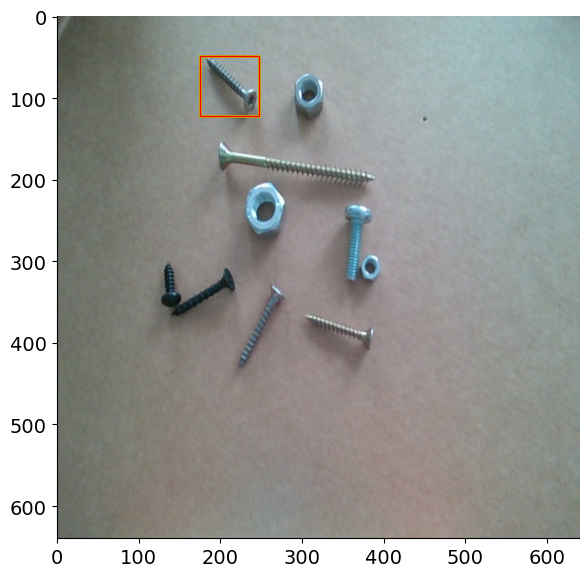

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the image
im = cv2.imread('/home/alesmelichar/Dev/network/client/datasets/images/screws_001.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Original bounding box (top_left_x, top_left_y, width, height) in pixels
bbox_pixels = np.array([210.98019801980197, 85.2128712871287, 72, 73])

# Convert to YOLO format (x_center, y_center, width, height) in normalized coordinates
bbox_yolo = [bbox_pixels[0] / im.shape[1], # x_center
             bbox_pixels[1] / im.shape[0], # y_center
             bbox_pixels[2] / im.shape[1], # width
             bbox_pixels[3] / im.shape[0]] # height

# Convert YOLO format back to matplotlib format for visualization
bbox_mpl = [(bbox_yolo[0] - bbox_yolo[2] / 2.0) * im.shape[1], # top_left_x
            (bbox_yolo[1] - bbox_yolo[3] / 2.0) * im.shape[0], # top_left_y
            bbox_yolo[2] * im.shape[1], # width
            bbox_yolo[3] * im.shape[0]] # height


bbox[0] = bbox_pixels[0] - bbox_pixels[2] / 2.0  # x - width / 2
bbox[1] = bbox_pixels[1] - bbox_pixels[3] / 2.0  # y - height / 2
bbox[2] = bbox_pixels[2]
bbox[3] = bbox_pixels[3]

print(bbox)

# Create figure and axes
fig, ax = plt.subplots(1)

rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=2,edgecolor='y',facecolor='none')
ax.add_patch(rect)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((bbox_mpl[0], bbox_mpl[1]), bbox_mpl[2], bbox_mpl[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()
